# Regressão Linear com PyTorch

## Objetivo

Este exemplo utiliza regressão linear para estimar o comprimento das sépalas da íris a partir do seu comprimento das pétalas.
Utiliza-se
- o cálculo do gradiente automático do PyTorch, porém
- a função de perda e
- atualização dos parâmetros é feita de forma explícita.
- A rede é criada com uma camada nn.Linear()

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinear_Otimizacao.png)

## Importação dos pacotes

In [2]:
# 1. Instala as versões mais recentes do PyTorch e Torchvision.
#    Em ambientes com GPU (como o Colab), isso instala automaticamente a versão compatível.
!pip install -q torch torchvision

# 2. Importa o pacote PyTorch para uso.
import torch

# Verificação opcional
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cu126
CUDA available: False


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from sklearn.datasets import load_iris

import torch
from torch import nn, optim
from torch.autograd import Variable

torch.manual_seed(1234)

## Leitura dos dados

In [4]:
iris = load_iris()
data = iris.data[iris.target==1,::2]  # comprimento das sépalas e pétalas, indices 0 e 2

x_train = data[:,0:1].astype(np.float32)
y_train = data[:,1:2].astype(np.float32)

n_samples = x_train.shape[0]
print('x_train.shape:',x_train.shape, x_train.dtype)
print('y_train.shape:',y_train.shape, y_train.dtype)

print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train.shape: (50, 1) float32
y_train.shape: (50, 1) float32
x_train[:5]:
 [[7. ]
 [6.4]
 [6.9]
 [5.5]
 [6.5]]
y_train[:5]:
 [[4.7]
 [4.5]
 [4.9]
 [4. ]
 [4.6]]


### Normalização dos dados

In [5]:
x_train -= x_train.min()
x_train /= x_train.max()
y_train -= y_train.min()
y_train /= y_train.max()


In [6]:
print('x_train[:5]:\n', x_train[:5])
print('y_train[:5]:\n', y_train[:5])

x_train[:5]:
 [[1.        ]
 [0.71428573]
 [0.952381  ]
 [0.28571424]
 [0.7619048 ]]
y_train[:5]:
 [[0.80952376]
 [0.71428573]
 [0.90476197]
 [0.4761905 ]
 [0.7619048 ]]


In [7]:
x_train_bias = np.hstack([np.ones(shape=(n_samples,1)), x_train])

In [8]:
x_train_bias

array([[1.        , 1.        ],
       [1.        , 0.71428573],
       [1.        , 0.95238101],
       [1.        , 0.28571424],
       [1.        , 0.76190478],
       [1.        , 0.38095227],
       [1.        , 0.66666675],
       [1.        , 0.        ],
       [1.        , 0.80952376],
       [1.        , 0.14285702],
       [1.        , 0.047619  ],
       [1.        , 0.47619051],
       [1.        , 0.52380949],
       [1.        , 0.57142848],
       [1.        , 0.33333325],
       [1.        , 0.85714275],
       [1.        , 0.33333325],
       [1.        , 0.42857149],
       [1.        , 0.61904752],
       [1.        , 0.33333325],
       [1.        , 0.47619051],
       [1.        , 0.57142848],
       [1.        , 0.66666675],
       [1.        , 0.57142848],
       [1.        , 0.71428573],
       [1.        , 0.80952376],
       [1.        , 0.90476197],
       [1.        , 0.85714275],
       [1.        , 0.52380949],
       [1.        , 0.38095227],
       [1.

In [9]:
print('x_train_bias.shape:',x_train_bias.shape, x_train_bias.dtype)

x_train_bias.shape: (50, 2) float64


In [10]:
x_train_bias = torch.FloatTensor(x_train_bias)
y_train      = torch.FloatTensor(y_train)
print(y_train)

tensor([[0.8095],
        [0.7143],
        [0.9048],
        [0.4762],
        [0.7619],
        [0.7143],
        [0.8095],
        [0.1429],
        [0.7619],
        [0.4286],
        [0.2381],
        [0.5714],
        [0.4762],
        [0.8095],
        [0.2857],
        [0.6667],
        [0.7143],
        [0.5238],
        [0.7143],
        [0.4286],
        [0.8571],
        [0.4762],
        [0.9048],
        [0.8095],
        [0.6190],
        [0.6667],
        [0.8571],
        [0.9524],
        [0.7143],
        [0.2381],
        [0.3810],
        [0.3333],
        [0.4286],
        [1.0000],
        [0.7143],
        [0.7143],
        [0.8095],
        [0.6667],
        [0.5238],
        [0.4762],
        [0.6667],
        [0.7619],
        [0.4762],
        [0.1429],
        [0.5714],
        [0.5714],
        [0.5714],
        [0.6190],
        [0.0000],
        [0.5238]])


## Model

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoLinearNeuronio.png)

In [11]:
model = torch.nn.Linear(in_features=2, out_features=1, bias=False)

### Verificando a inicialização dos parâmetros

In [12]:
model.weight.data = torch.zeros(1,2)
torch.nn.init.uniform(model.weight.data, -0.1, 0.1)
model.weight

/tmp/ipython-input-2197199425.py:2: FutureWarning: `nn.init.uniform` is now deprecated in favor of `nn.init.uniform_`.
  torch.nn.init.uniform(model.weight.data, -0.1, 0.1)


Parameter containing:
tensor([[-0.0480, -0.0267]], requires_grad=True)

### Testando o predict da rede

In [13]:
xx = torch.ones((5,2))
xx

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])

In [14]:
model(Variable(xx))

tensor([[-0.0747],
        [-0.0747],
        [-0.0747],
        [-0.0747],
        [-0.0747]], grad_fn=<MmBackward0>)

## Treinamento

In [16]:
num_epochs = 100
learning_rate = 0.5
for epoch in range(num_epochs):
    inputs = Variable(x_train_bias)
    target = Variable(y_train)

    # forward - predict
    out = model(inputs)

    #loss cálculo da função de perda
    loss = torch.pow(out - target, 2).mean()
    print('loss:',loss.data.numpy())

    # backward propagation - cálculo gradiente
    loss.backward()

    # gradiente descendente
    model.weight.data = model.weight.data - learning_rate * model.weight.grad.data

    # zeragem parâmetros próximo cálculo do gradiente
    model.weight.grad.data.zero_()

    # verbose
    if (epoch+1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.item()))

loss: 0.022816122
loss: 0.022664463
loss: 0.022526773
loss: 0.022401761
loss: 0.022288265
loss: 0.022185221
loss: 0.02209167
loss: 0.022006733
loss: 0.021929614
loss: 0.021859605
loss: 0.02179604
loss: 0.021738332
loss: 0.021685934
loss: 0.021638365
loss: 0.021595178
loss: 0.021555966
loss: 0.021520365
loss: 0.021488044
loss: 0.021458704
loss: 0.021432059
Epoch[20/100], loss: 0.021432
loss: 0.021407869
loss: 0.02138591
loss: 0.021365972
loss: 0.02134787
loss: 0.021331435
loss: 0.021316513
loss: 0.021302966
loss: 0.02129067
loss: 0.021279499
loss: 0.021269362
loss: 0.02126016
loss: 0.021251803
loss: 0.021244213
loss: 0.021237329
loss: 0.021231074
loss: 0.021225395
loss: 0.02122024
loss: 0.021215564
loss: 0.021211311
loss: 0.021207454
Epoch[40/100], loss: 0.021207
loss: 0.021203952
loss: 0.02120077
loss: 0.021197883
loss: 0.021195265
loss: 0.021192882
loss: 0.021190722
loss: 0.021188762
loss: 0.02118698
loss: 0.021185363
loss: 0.021183899
loss: 0.021182563
loss: 0.02118135
loss: 0.021180

## Avaliação

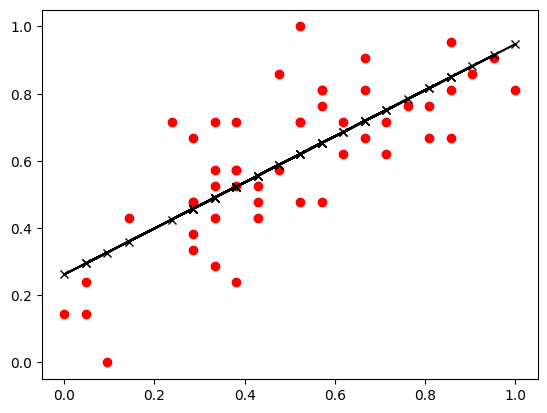

In [17]:
y_pred = model(Variable(x_train_bias))
plt.plot(x_train, y_train.numpy(), 'ro', label='Original data')
plt.plot(x_train, y_pred.data.numpy(), 'kx-', label='Fitting Line')
plt.show()

### Acessando os parâmetros

In [18]:
w_dic = model.state_dict()
w_dic

OrderedDict([('weight', tensor([[0.2620, 0.6851]]))])

### Parâmetros ótimos, solução analítica

In [19]:
x_bias = x_train_bias
y = y_train
x_bias_t = torch.t(x_bias)
w_opt = (torch.inverse(x_bias_t.mm(x_bias)).mm(x_bias_t)).mm(y)
print(torch.t(w_opt))

tensor([[0.2613, 0.6865]])


# Exercícios

- 1) Por que no final da varredura do laço de treinamento, a perda é impressa utilizando
   `loss.data[0]`? Por que precisa do `data` e por que precisa da indexação por zero?
> Por que com este comando você acessa somente o valor numérico do tensor, sem a ligação com o grafo computacional. É preciso utilizar o 'data' para imprimir o valor da perda sem carregar o grafo na memória.

- 2) Calcule e imprima o valor da perda (MSE) fazendo o predict da rede com os pesos já
   treinados.

In [20]:
# 2) Cálculo da perda final com pesos já treinados
with torch.no_grad():  # desativa gradientes
    y_pred = model(x_train_bias)             # predição com pesos finais
    mse_loss = torch.mean((y_pred - y_train) ** 2)
    print(f"Perda final (MSE) com pesos treinados: {mse_loss.item():.6f}")

Perda final (MSE) com pesos treinados: 0.021170


- 3) Crie duas listas `w0_list` e `w1_list` para guardar a evolução dos valores dos
   parâmetros durante o laço de treinamento.
   Modifique o exemplo do gráfico tipo **scatter plot** para visualizar a variação
   dos parâmetros do modelo duas dimensões.
   Marque neste gráfico o valor ótimo do parâmetro dado pela solução
   analítica.

In [21]:
# Listas para acompanhar a evolução dos parâmetros
w0_list = []
w1_list = []

# Inicializa o modelo (reinicialização, para ter um caminho completo)
model = torch.nn.Linear(in_features=2, out_features=1, bias=False)
model.weight.data = torch.zeros(1,2)
torch.nn.init.uniform_(model.weight.data, -0.1, 0.1) # Note: uniform_ é a versão atualizada (in-place)

num_epochs = 100
learning_rate = 0.5

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    # Forward
    y_pred = model(x_train_bias)
    loss = criterion(y_pred, y_train)

    # Zerar gradientes e backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Salvar pesos após cada atualização
    # Extraímos os valores com .item()
    w0_list.append(model.weight.data[0, 0].item())
    w1_list.append(model.weight.data[0, 1].item())

    if (epoch+1) % 20 == 0:
        print(f'Época [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Época [20/100], Loss: 0.022719
Época [40/100], Loss: 0.021394
Época [60/100], Loss: 0.021202
Época [80/100], Loss: 0.021174
Época [100/100], Loss: 0.021170


## Ploting vectors

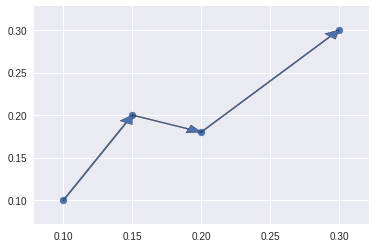

In [ ]:
# Exemplo
w0_list = [0.1, 0.15, 0.2, 0.3]
w1_list = [0.1, 0.2, 0.18, 0.3]
plt.scatter(w0_list,w1_list)
w0_old = None
for (w0,w1) in zip(w0_list,w1_list):
    if w0_old:
        plt.arrow(w0_old, w1_old, w0-w0_old, w1-w1_old,
                  head_length=0.01,head_width=0.01,shape='full',
                  length_includes_head=True)
    w0_old,w1_old = w0,w1


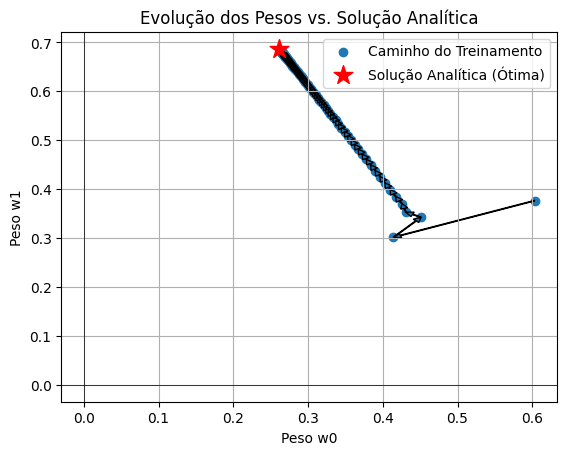

In [22]:
w0_analitico = w_opt[0].item() # Extraído da célula 16
w1_analitico = w_opt[1].item() # Extraído da célula 16

plt.scatter(w0_list, w1_list, label='Caminho do Treinamento')
# O segundo plt.scatter(w0_list,w1_list) é redundante, mas não causa erro.

w0_old = None
for (w0,w1) in zip(w0_list,w1_list):
    if w0_old:
        plt.arrow(w0_old, w1_old, w0-w0_old, w1-w1_old,
                  head_length=0.01,head_width=0.01,shape='full',
                  length_includes_head=True)
    w0_old,w1_old = w0,w1


plt.scatter(w0_analitico, w1_analitico,
            c='red',
            marker='*',
            s=200,
            zorder=5,
            label='Solução Analítica (Ótima)')

plt.xlabel('Peso w0')
plt.ylabel('Peso w1')
plt.title('Evolução dos Pesos vs. Solução Analítica')
plt.legend()
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5) # Eixo x
plt.axvline(0, color='black', linewidth=0.5) # Eixo y
plt.show()

# Aprendizados